In [105]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,lower
import pandas as pd
import numpy as np
import nltk
import re
from gensim.parsing.preprocessing import remove_stopwords
from textblob import TextBlob
import matplotlib
import matplotlib.pyplot as plt

Connecting the Spark with MongoDB for Reading Data

In [106]:
database_uri = "mongodb://127.0.0.1:27017/review_data.reviews"
my_spark = SparkSession\
    .builder\
    .appName("MyApp")\
    .config("spark.mongodb.input.uri", database_uri)\
    .config("spark.mongodb.output.uri", database_uri)\
    .config('spark.jars.packages','org.mongodb.spark:mongo-spark-connector_2.12:3.0.1')\
    .getOrCreate()

Extracting Data related to Alexa for EDA and Data PreProcessing

In [107]:
df = my_spark.read.format('com.mongodb.spark.sql.DefaultSource').load()
# result=my_spark.sql("select * from df where reviewText like '%alexa%' ")
df_filtered = df.filter(col("reviewText").like("%alexa%"))
df_filtered.show()                    

+--------------------+----------+-------+--------------------+-----------+--------------+--------------------+--------------+--------+
|                 _id|      asin|overall|          reviewText| reviewTime|    reviewerID|             summary|unixReviewTime|verified|
+--------------------+----------+-------+--------------------+-----------+--------------+--------------------+--------------+--------+
|{644ead17f66a6378...|B017O9P72A|    1.0|The service works...|12 29, 2017| AA4DHYT5YSSIT|       Does not work|    1514505600|   false|
|{644ead17f66a6378...|B017O9P72A|    2.0|I have to tell al...|07 24, 2017|A1ZH6WTMUGWCOU|Commands need to ...|    1500854400|   false|
|{644ead17f66a6378...|B017O9P72A|    3.0|Null message fixe...| 01 5, 2017|A2XD433O61HBZZ|Log out to fix nu...|    1483574400|   false|
|{644ead17f66a6378...|B017O9P72A|    1.0|When I try to lin...|09 15, 2016|A2ZJTS4QMA52IV|Error trying to A...|    1473897600|   false|
|{644ead17f66a6378...|B017O9P72A|    2.0|Horrible,  abs

In [108]:
df2= pd.DataFrame()
df2=df_filtered.toPandas()
file_name = 'Alexa_reviews.xlsx'
df2.to_excel(file_name)
df2

,_id,asin,overall,reviewText,reviewTime,reviewerID,summary,unixReviewTime,verified
0,"(644ead17f66a6378caeef939,)",B017O9P72A,1.0,"The service works with google home, but doesn'...","12 29, 2017",AA4DHYT5YSSIT,Does not work,1514505600,False
1,"(644ead17f66a6378caeef944,)",B017O9P72A,2.0,I have to tell alexa to tell lifx to do things...,"07 24, 2017",A1ZH6WTMUGWCOU,Commands need to get shorter!!!!,1500854400,False
2,"(644ead17f66a6378caeef959,)",B017O9P72A,3.0,Null message fixed by logging out!!! Log out a...,"01 5, 2017",A2XD433O61HBZZ,Log out to fix null message,1483574400,False
3,"(644ead17f66a6378caeef986,)",B017O9P72A,1.0,When I try to link this app to the alexa app I...,"09 15, 2016",A2ZJTS4QMA52IV,Error trying to Authorize,1473897600,False
4,"(644ead17f66a6378caeef9a1,)",B017O9P72A,2.0,"Horrible, absolutely amateur coding without t...","03 10, 2016",A2AQ4B1526F3F5,Underwhelming integration and no voice color c...,1457568000,False
...,...,...,...,...,...,...,...,...,...
1120,"(644eb2d6f66a6378caf88a29,)",B000QOMZT4,5.0,work awesome -- kids love them on their lofted...,"03 12, 2018",A3JY1C2IPMF5VD,work awesome -- kids love them on their lofted...,1520812800,True
1121,"(644eb2ddf66a6378caf9b0cd,)",B0011DRCA6,5.0,I collect the madame alexander dolls. I am mis...,"04 14, 2014",AEOFFQLA211OI,dolls,1397433600,True
1122,"(644eb2e5f66a6378cafd7f00,)",B001TO6RDA,5.0,"This chart is easy to read, big, and packed fu...","07 16, 2017",A2G8BMSSXK0GBW,Every kitchen should have one,1500163200,True
1123,"(644eb2ebf66a6378ca001410,)",B003B1UPEG,3.0,it was ok my son uses it most but the bottom s...,"01 3, 2016",A34IMTGNKI43BE,so its garbage now. no more brandy alexanders ...,1451779200,False


# Preprocess and clean the data as necessary for training the model.You will preprocess and clean the data as necessary for trainingthe recommendation model. This may involve handling missing values,transforming categorical variables, normalizing the data, and feature engineering.(10 Marks)

In [109]:
# Run this query through pysql go access data related to Alexa for Preprocessing and Performing Exploratory Data Analysis

# df_filtered = df.filter(col("reviewText").like("%alexa%"))

#Loading and PreProcessing the extracted data
df2= pd.read_excel('Alexa_reviews.xlsx')
#dropping unnecessary columns
df2.drop(['_id','asin','reviewerID','unixReviewTime'], axis=1,inplace=True)
df2

,Unnamed: 0,overall,reviewText,reviewTime,summary,verified
0,0,1,"The service works with google home, but doesn'...","12 29, 2017",Does not work,False
1,1,2,I have to tell alexa to tell lifx to do things...,"07 24, 2017",Commands need to get shorter!!!!,False
2,2,3,Null message fixed by logging out!!! Log out a...,"01 5, 2017",Log out to fix null message,False
3,3,1,When I try to link this app to the alexa app I...,"09 15, 2016",Error trying to Authorize,False
4,4,2,"Horrible, absolutely amateur coding without t...","03 10, 2016",Underwhelming integration and no voice color c...,False
...,...,...,...,...,...,...
1120,1120,5,work awesome -- kids love them on their lofted...,"03 12, 2018",work awesome -- kids love them on their lofted...,True
1121,1121,5,I collect the madame alexander dolls. I am mis...,"04 14, 2014",dolls,True
1122,1122,5,"This chart is easy to read, big, and packed fu...","07 16, 2017",Every kitchen should have one,True
1123,1123,3,it was ok my son uses it most but the bottom s...,"01 3, 2016",so its garbage now. no more brandy alexanders ...,False


In this cell we are doing Data Cleaning for efficient Sentiment Analysis by lower casing,removing stop words and removing alphanumeric Characters of the Review Column


In [110]:
review_sentiment=[]
df_range=len(df2)
for i in range(df_range):
    text=df2.iat[i,2]
    #LowerCasing
    text = text.lower()
    #Removing Alphanumeric
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    #removing Stopwords
    text = remove_stopwords(text)
    #Performing Sentiment Analysis
    x=TextBlob(text)
    sentiment=x.sentiment.polarity
    review_sentiment.append(round(sentiment,2))
    
    
# review_sentiment    

Transforming Categorical Columns

In [111]:
# converting date to DateTime format
df2['reviewTime']= pd.to_datetime(df2['reviewTime'])
df2['sentiment'] =review_sentiment
#Applying One-Hot Encoding on Verified Column
df2["verified"] = df2["verified"].astype(int)
df2['Year'] = df2['reviewTime'].dt.year
#Dropping unneccesiary Columns
df2.drop(['Unnamed: 0','reviewText','summary'], axis=1,inplace=True)
df2


,overall,reviewTime,verified,sentiment,Year
0,1,2017-12-29,0,0.50,2017
1,2,2017-07-24,0,0.01,2017
2,3,2017-01-05,0,0.09,2017
3,1,2016-09-15,0,0.00,2016
4,2,2016-03-10,0,-0.01,2016
...,...,...,...,...,...
1120,5,2018-03-12,1,0.57,2018
1121,5,2014-04-14,1,0.37,2014
1122,5,2017-07-16,1,0.17,2017
1123,3,2016-01-03,0,-0.20,2016


# Perform exploratory data analysis (EDA) on the dataset to gain insights into the data

Extracting the Positive Reviews per year to Analyze the progress of the product

In [112]:
no_sentiment=[]
df3=df2.where(df2.sentiment > 0.0)
df3.dropna(inplace=True)
df3
years=df2["Year"].unique()

pos_senti_2001=df3["Year"].where(df3["Year"]==2001).count()
pos_senti_2002=df3["Year"].where(df3["Year"]==2002).count()
pos_senti_2003=df3["Year"].where(df3["Year"]==2003).count()
pos_senti_2004=df3["Year"].where(df3["Year"]==2004).count()
pos_senti_2005=df3["Year"].where(df3["Year"]==2005).count()
pos_senti_2006=df3["Year"].where(df3["Year"]==2006).count()
pos_senti_2007=df3["Year"].where(df3["Year"]==2008).count()
pos_senti_2009=df3["Year"].where(df3["Year"]==2009).count()
pos_senti_2010=df3["Year"].where(df3["Year"]==2010).count()
pos_senti_2011=df3["Year"].where(df3["Year"]==2011).count()
pos_senti_2012=df3["Year"].where(df3["Year"]==2012).count()
pos_senti_2013=df3["Year"].where(df3["Year"]==2013).count()
pos_senti_2014=df3["Year"].where(df3["Year"]==2014).count()
pos_senti_2015=df3["Year"].where(df3["Year"]==2015).count()
pos_senti_2016=df3["Year"].where(df3["Year"]==2016).count()
pos_senti_2017=df3["Year"].where(df3["Year"]==2017).count()
pos_senti_2018=df3["Year"].where(df3["Year"]==2018).count()
no_sentiment.append(pos_senti_2001)
no_sentiment.append(pos_senti_2002)
no_sentiment.append(pos_senti_2003)
no_sentiment.append(pos_senti_2004)
no_sentiment.append(pos_senti_2005)
no_sentiment.append(pos_senti_2006)
no_sentiment.append(pos_senti_2007)
no_sentiment.append(pos_senti_2009)
no_sentiment.append(pos_senti_2010)
no_sentiment.append(pos_senti_2011)
no_sentiment.append(pos_senti_2012)
no_sentiment.append(pos_senti_2013)
no_sentiment.append(pos_senti_2014)
no_sentiment.append(pos_senti_2015)
no_sentiment.append(pos_senti_2016)
no_sentiment.append(pos_senti_2017)
no_sentiment.append(pos_senti_2018)
no_sentiment
df2['Year'] = df2['reviewTime'].dt.year
# no_sentiment
# years=df2["Year"].unique()
# years



Extracting the Negative Reviews per year to Analyze the validity later version  of the product

In [113]:
no_neg_sentiment=[]
df4=df2.where(df2.sentiment < 0.0)
df4.dropna(inplace=True)
df4

neg_senti_2001=df4["Year"].where(df4["Year"]==2001).count()
neg_senti_2002=df4["Year"].where(df4["Year"]==2002).count()
neg_senti_2003=df4["Year"].where(df4["Year"]==2003).count()
neg_senti_2004=df4["Year"].where(df4["Year"]==2004).count()
neg_senti_2005=df4["Year"].where(df4["Year"]==2005).count()
neg_senti_2006=df4["Year"].where(df4["Year"]==2006).count()
neg_senti_2007=df4["Year"].where(df4["Year"]==2008).count()
neg_senti_2009=df4["Year"].where(df4["Year"]==2009).count()
neg_senti_2010=df4["Year"].where(df4["Year"]==2010).count()
neg_senti_2011=df4["Year"].where(df4["Year"]==2011).count()
neg_senti_2012=df4["Year"].where(df4["Year"]==2012).count()
neg_senti_2013=df4["Year"].where(df4["Year"]==2013).count()
neg_senti_2014=df4["Year"].where(df4["Year"]==2014).count()
neg_senti_2015=df4["Year"].where(df4["Year"]==2015).count()
neg_senti_2016=df4["Year"].where(df4["Year"]==2016).count()
neg_senti_2017=df4["Year"].where(df4["Year"]==2017).count()
neg_senti_2018=df4["Year"].where(df4["Year"]==2018).count()
no_neg_sentiment.append(neg_senti_2001)
no_neg_sentiment.append(neg_senti_2002)
no_neg_sentiment.append(neg_senti_2003)
no_neg_sentiment.append(neg_senti_2004)
no_neg_sentiment.append(neg_senti_2005)
no_neg_sentiment.append(neg_senti_2006)
no_neg_sentiment.append(neg_senti_2007)
no_neg_sentiment.append(neg_senti_2009)
no_neg_sentiment.append(neg_senti_2010)
no_neg_sentiment.append(neg_senti_2011)
no_neg_sentiment.append(neg_senti_2012)
no_neg_sentiment.append(neg_senti_2013)
no_neg_sentiment.append(neg_senti_2014)
no_neg_sentiment.append(neg_senti_2015)
no_neg_sentiment.append(neg_senti_2016)
no_neg_sentiment.append(neg_senti_2017)
no_neg_sentiment.append(neg_senti_2018)


In [114]:
years=[]
years=df2["Year"].unique()
years=np.sort(years)
years=years.tolist()


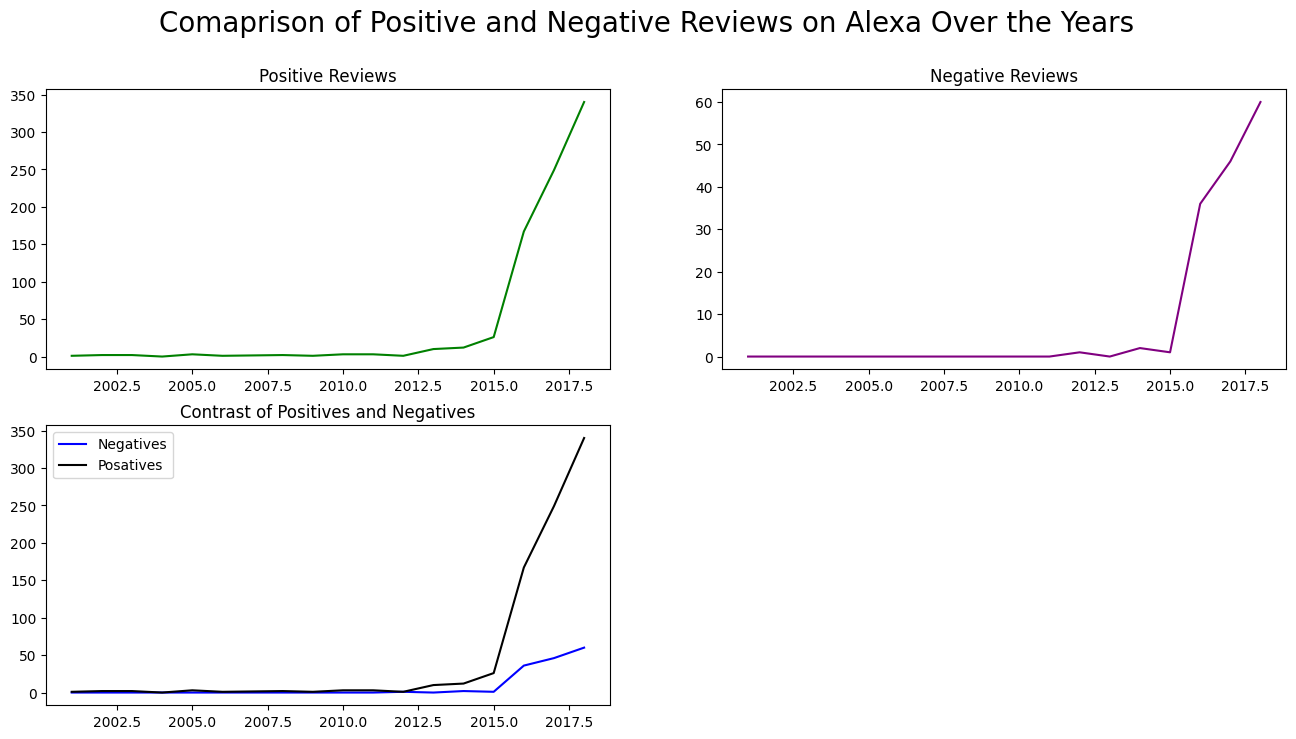

In [121]:
fig = plt.figure(figsize=(16,8))

fig.suptitle('Comaprison of Positive and Negative Reviews on Alexa Over the Years', 
             fontsize=20)
ax1 = fig.add_subplot(221)
ax1.set_title('Positive Reviews')
ax1.plot(years,no_sentiment,color='green')

ax2 = fig.add_subplot(222)
ax2.set_title('Negative Reviews')
ax2.plot(years,no_neg_sentiment,color='purple')

ax3 = fig.add_subplot(223)
ax3.set_title('Contrast of Positives and Negatives')
ax3.plot(years,no_neg_sentiment,color='blue',label="Negatives")
ax3.plot(years,no_sentiment,color='black',label="Posatives")
ax3.legend()



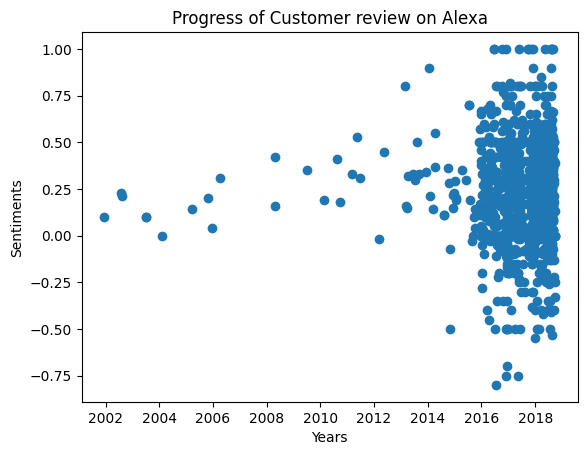

In [104]:
plt.scatter(df2["reviewTime"], df2["sentiment"])
plt.xlabel("Years")
plt.ylabel("Sentiments")
plt.title("Progress of Customer review on Alexa")
plt.show()

In [116]:
corr=df2['Year'].corr(df2['sentiment'])
print(corr)

0.00854466374699146


In [117]:
no_reviews_per_year=[]
for i in range(len(years)):
    no_reviews_per_year.append(df2["Year"].where(df2["Year"]==years[i]).count())
no_reviews_per_year

[1, 2, 2, 1, 3, 1, 2, 1, 3, 3, 2, 10, 14, 30, 239, 355, 456]

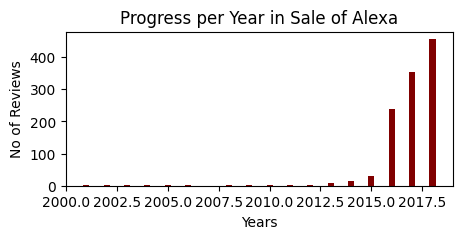

In [118]:
fig = plt.figure(figsize = (5, 2))
 
# creating the bar plot
plt.bar(years, no_reviews_per_year, color ='maroon',width = 0.3)
 
plt.xlabel("Years")
plt.ylabel("No of Reviews")
plt.title("Progress per Year in Sale of Alexa")
plt.show()

# Conclusions based on Exploratory Data Analysis 

1) From the figure 1 we can see that from the year 2001 to 2015 the Product Alexa was doing not well.
2) After the year 2015 there is a rapid increase in the reviews which indicates the higher sale as a result of advance features    and better marketing Strategies.
3) Another observation is that there is an increase in positive reviews whareas the negative reviews are only limited to approximately 60 hence the EDA proves the better quality of Alexa 
4) From the Scattered plot we can see that there is positive coorelation between the years the sentiments.
5) Non Availabality of Year 2007 shows the termination of sale of the Product in 2007 and relaunch in 2008.